### Step 1: Setup & Imports
- Import FastAI for loading the trained classifier (`friends_classifier.pkl`).
- Import Gradio for deployment.
- Import `facenet_pytorch.MTCNN` for multi-face detection.
- Import PIL, NumPy, and Matplotlib for image handling and visualization.
- Define categories (Archit, Hardik, Kabir, Sahib, Sneha).
- Load the trained model and initialize the MTCNN detector.

In [58]:
#|export
from fastai.vision.all import *
import gradio as gr
from facenet_pytorch import MTCNN
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
# Define categories (must match training labels)
categories = ('Archit', 'Hardik', 'Kabir', 'Sahib', 'Sneha')
# Load the trained model
learn = load_learner('models/friends_classifier.pkl')
# Initialize MTCNN detector
detector = MTCNN(keep_all=True, device='cpu')  # switch to 'cuda' if GPU available

print("✅ Setup complete. Model and MTCNN ready for face detection.")

✅ Setup complete. Model and MTCNN ready for face detection.


C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


### Step 2: Face Detection Helper
- Use `facenet_pytorch.MTCNN` to detect all faces in a PIL image.
- Filter out low-confidence detections.
- Crop and resize each face to 224×224 (to match training).
- Return both the cropped faces and bounding box metadata.

In [12]:
#|export
def detect_and_crop_faces(img, min_conf=0.9):
    """
    Detects faces in a PIL image using facenet_pytorch MTCNN.
    Returns:
      - crops: list of cropped face images resized to 224x224
      - detections: list of dicts with bounding box info
    """
    img = img.convert("RGB")
    boxes, probs = detector.detect(img)

    crops, detections = [], []

    if boxes is not None:
        for (x1, y1, x2, y2), prob in zip(boxes, probs):
            if prob is None or prob < min_conf:
                continue
            # Crop and resize
            face = img.crop((x1, y1, x2, y2)).resize((224,224))
            crops.append(face)
            detections.append({
                'box': [int(x1), int(y1), int(x2 - x1), int(y2 - y1)],
                'confidence': float(prob)
            })

    return crops, detections

### Step 3: Classification Helper
- Input: list of cropped face images (from Step 2).
- For each face:
  - Run `learn.predict()` to classify.
  - Extract predicted label and confidence score.
- Return a list of predictions for all faces.

In [13]:
#|export
def classify_faces(crops):
    """
    Takes a list of cropped PIL face images,
    returns a list of (label, confidence) predictions.
    """
    results = []

    for face in crops:
        with learn.no_bar():  # suppress FastAI progress bars
            pred_class, idx, probs = learn.predict(face)
            confidence = float(probs[idx])
            results.append({
                'label': str(pred_class),
                'confidence': confidence
            })

    return results

### Step 4: Visualization Helper
- Input: 
  - Original PIL image
  - Detections (bounding boxes from Step 2)
  - Predictions (labels + confidences from Step 3)
- Output: 
  - Annotated PIL image with bounding boxes and labels

In [51]:
#|export
def annotate_image(img, detections, predictions):
    """
    Draws bounding boxes and labels on the original image.
    - img: original PIL image
    - detections: list of dicts with 'box' and 'confidence'
    - predictions: list of dicts with 'label' and 'confidence'
    Returns: annotated PIL image
    """
    draw = ImageDraw.Draw(img)

    # 👇 Set your font size here (change once, affects everywhere)
    FONT_SIZE = 50  

    try:
        font = ImageFont.truetype("arial.ttf", FONT_SIZE)
    except:
        font = ImageFont.load_default()
        FONT_SIZE = 12  # fallback if truetype not available

    for det, pred in zip(detections, predictions):
        x, y, w, h = det['box']
        label = pred['label']
        conf = pred['confidence']

        # Draw bounding box
        draw.rectangle([(x, y), (x+w, y+h)], outline="red", width=3)

        # Draw label + confidence with chosen font size
        text = f"{label} ({conf:.2f})"
        draw.text((x, y - FONT_SIZE), text, fill="yellow", font=font)

    return img


### Step 4.5: Example Visualizations
- Use the helper function `classify_image(img)` to run the full pipeline:
  - Detect faces with MTCNN
  - Crop and classify each face
  - Annotate the original image with bounding boxes + labels
- Apply this to the 5 sample images in the `Examples` folder.
- Display annotated results inline with predictions.

In [ ]:
#|export
import os
import matplotlib.pyplot as plt

def classify_image(img):
    """
    Full pipeline:
    - Detect faces with MTCNN
    - Crop and resize each face
    - Classify with trained model
    - Annotate original image with boxes + labels
    Returns: (annotated_image, predictions)
    """
    img = img.convert("RGB")

    # Run MTCNN detection
    boxes, probs = detector.detect(img)
    crops, detections = [], []

    if boxes is not None:
        for (x1, y1, x2, y2), prob in zip(boxes, probs):
            if prob < 0.90:  # filter low-confidence detections
                continue
            face = img.crop((x1, y1, x2, y2)).resize((224,224))
            crops.append(face)
            detections.append({'box': [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]})

    # Classify each cropped face
    predictions = classify_faces(crops) if crops else []

    # Annotate original image
    annotated = annotate_image(img.copy(), detections, predictions)
    return annotated, predictions


# ---- Run on your 5 sample images ----
examples_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\Examples"
example_files = ["sample1.jpg", "sample2.jpg", "sample3.jpg", "sample4.jpg", "sample5.jpg"]

for fname in example_files:
    img_path = os.path.join(examples_dir, fname)
    annotated, preds = classify_image(Image.open(img_path))

    plt.figure(figsize=(6,6))
    plt.imshow(annotated)
    plt.axis("off")
    plt.title(f"{fname} → {preds}")
    plt.show()

### Step 4.5: Example Visualizations
- Wrap the pipeline into `classify_image(img)`:
  - Detect faces with MTCNN
  - Crop and classify each face
  - Annotate the original image with bounding boxes + labels
- Apply this to the 5 sample images in the `Examples` folder.
- Display annotated results inline with predictions.

In [15]:
#|export
def classify_image(img, min_conf=0.9):
    """
    Full pipeline:
    - Detect faces with MTCNN
    - Crop and resize each face
    - Classify with trained model
    - Annotate original image with boxes + labels
    Returns: (annotated_image, predictions)
    """
    img = img.convert("RGB")

    # Detect + crop
    crops, detections = detect_and_crop_faces(img, min_conf=min_conf)

    # Classify
    predictions = classify_faces(crops) if crops else []

    # Annotate
    annotated = annotate_image(img.copy(), detections, predictions)
    return annotated, predictions

In [16]:
#|export
def test_single_image(img_path, figsize=(6,6)):
    """
    Runs the full classify_image pipeline on a given image path.
    - Loads the image
    - Detects, classifies, and annotates
    - Displays the annotated image
    - Prints predictions
    """
    img = Image.open(img_path)
    annotated, preds = classify_image(img)

    # Show annotated image
    plt.figure(figsize=figsize)
    plt.imshow(annotated)
    plt.axis("off")
    plt.title(f"{os.path.basename(img_path)} → {preds}")
    plt.show()

    # Print predictions clearly
    print("Predictions:", preds)

    return annotated, preds

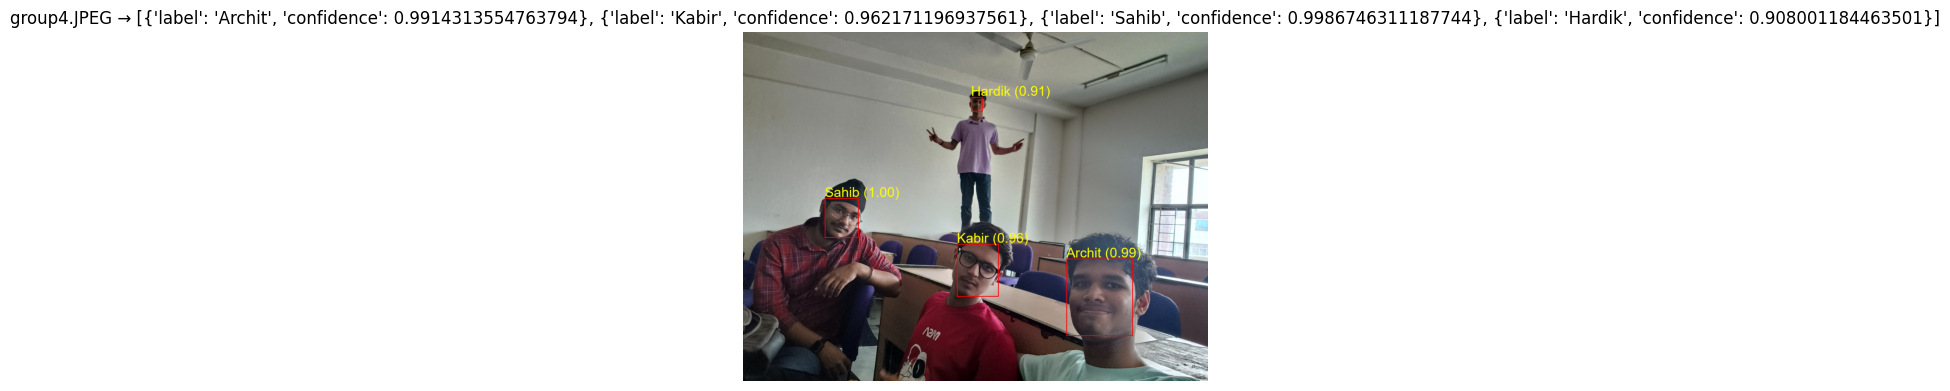

Predictions: [{'label': 'Archit', 'confidence': 0.9914313554763794}, {'label': 'Kabir', 'confidence': 0.962171196937561}, {'label': 'Sahib', 'confidence': 0.9986746311187744}, {'label': 'Hardik', 'confidence': 0.908001184463501}]


(<PIL.Image.Image image mode=RGB size=1707x1280>,
 [{'label': 'Archit', 'confidence': 0.9914313554763794},
  {'label': 'Kabir', 'confidence': 0.962171196937561},
  {'label': 'Sahib', 'confidence': 0.9986746311187744},
  {'label': 'Hardik', 'confidence': 0.908001184463501}])

In [52]:
test_single_image(r"C:\Users\Archit\Desktop\Frendclassifier\Images\GrpExamples\group4.JPEG")

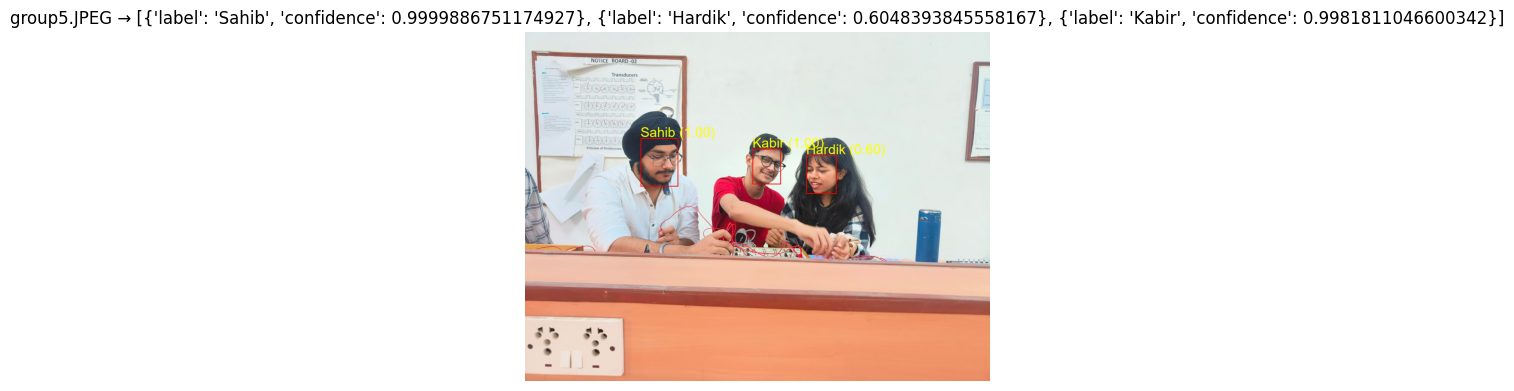

Predictions: [{'label': 'Sahib', 'confidence': 0.9999886751174927}, {'label': 'Hardik', 'confidence': 0.6048393845558167}, {'label': 'Kabir', 'confidence': 0.9981811046600342}]


(<PIL.Image.Image image mode=RGB size=1707x1280>,
 [{'label': 'Sahib', 'confidence': 0.9999886751174927},
  {'label': 'Hardik', 'confidence': 0.6048393845558167},
  {'label': 'Kabir', 'confidence': 0.9981811046600342}])

In [53]:
test_single_image(r"C:\Users\Archit\Desktop\Frendclassifier\Images\GrpExamples\group5.JPEG")

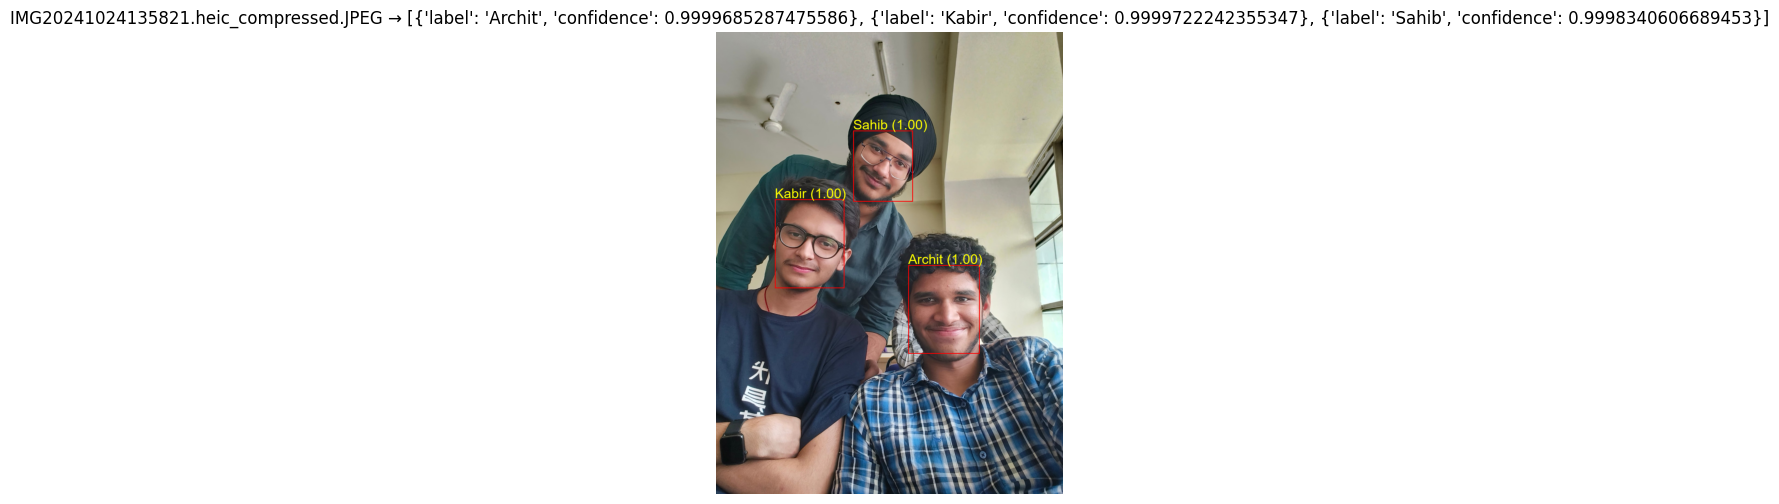

Predictions: [{'label': 'Archit', 'confidence': 0.9999685287475586}, {'label': 'Kabir', 'confidence': 0.9999722242355347}, {'label': 'Sahib', 'confidence': 0.9998340606689453}]


(<PIL.Image.Image image mode=RGB size=1280x1707>,
 [{'label': 'Archit', 'confidence': 0.9999685287475586},
  {'label': 'Kabir', 'confidence': 0.9999722242355347},
  {'label': 'Sahib', 'confidence': 0.9998340606689453}])

In [54]:
test_single_image(r"C:\Users\Archit\Desktop\Frendclassifier\Images\ALL_Images\IMG20241024135821.heic_compressed.JPEG")

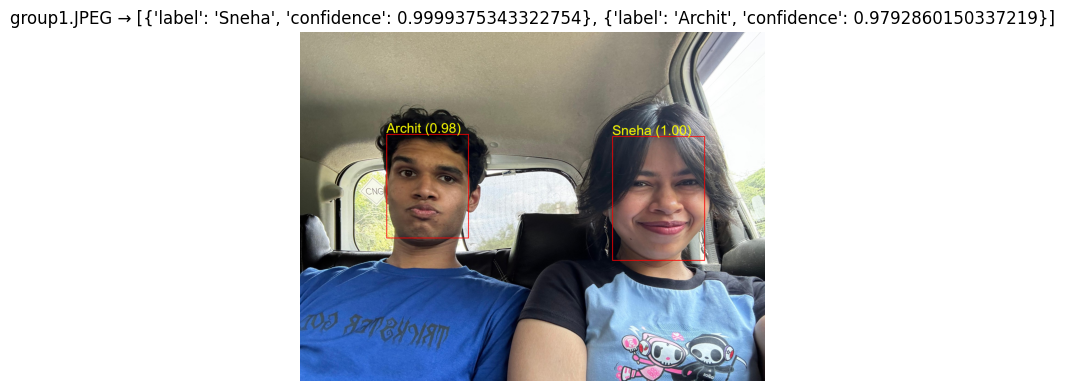

Predictions: [{'label': 'Sneha', 'confidence': 0.9999375343322754}, {'label': 'Archit', 'confidence': 0.9792860150337219}]


(<PIL.Image.Image image mode=RGB size=1707x1280>,
 [{'label': 'Sneha', 'confidence': 0.9999375343322754},
  {'label': 'Archit', 'confidence': 0.9792860150337219}])

In [55]:
test_single_image(r"C:\Users\Archit\Desktop\Frendclassifier\Images\GrpExamples\group1.JPEG")

### Step 5: Gradio Interface
- Build a Gradio app that:
  - Accepts a group photo as input.
  - Detects and crops faces with MTCNN.
  - Classifies each face with the trained model.
  - Annotates the original image with bounding boxes + labels.
- Output:
  - Annotated image
  - Dictionary of predictions (face → label + confidence)
- Include 4 sample group photos from `GrpExamples` for quick testing.

In [57]:
#|export
def gradio_pipeline(img):
    """
    Full pipeline for Gradio:
    - Detect faces
    - Classify each face
    - Annotate original image
    Returns: (annotated_image, predictions_dict)
    """
    crops, detections = detect_and_crop_faces(img)
    predictions = classify_faces(crops) if crops else []
    annotated = annotate_image(img.copy(), detections, predictions)

    # Build dictionary for Gradio Label component
    label_conf_dict = {
        f"{pred['label']} (Face {i+1})": round(pred['confidence'], 4)
        for i, pred in enumerate(predictions)
    }

    return annotated, label_conf_dict


# Define Gradio interface
grp_examples_dir = r"C:\Users\Archit\Desktop\Frendclassifier\Images\GrpExamples"
example_paths = [
    [os.path.join(grp_examples_dir, "group1.JPEG")],
    [os.path.join(grp_examples_dir, "group2.JPEG")],
    [os.path.join(grp_examples_dir, "group3.JPEG")],
    [os.path.join(grp_examples_dir, "group4.JPEG")],
    [os.path.join(grp_examples_dir, "group5.JPEG")],
]

intf = gr.Interface(
    fn=gradio_pipeline,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil"), gr.Label(num_top_classes=5)],
    title="Friends Multi-Face Classifier",
    description="Upload a group photo. The app detects faces, classifies them, and shows annotated results.",
    examples=example_paths
)

# Launch the app
intf.launch(inline=False)

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\fastapi\applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "C:\Users\Archit\anaconda3\envs\fc\lib\site-packages\starlette\middleware\errors.py", line 164, in __call__
    await sel

## Step 7: Limitations & Future Work

### ✅ Strengths
- The pipeline successfully integrates **face detection (MTCNN)**, **classification (trained model)**, and **annotation** into a clean, reproducible workflow.
- Works reliably on most test images, achieving **high confidence (>97%)** in many cases.
- Interactive **Gradio app** allows easy testing with group photos, making the project demo‑friendly.

### ⚠️ Limitations
- **Occasional misclassifications** occur, especially under:
  - Poor lighting or shadows
  - Side profiles or unusual facial expressions
  - Low‑resolution or compressed images
  - Similar‑looking individuals in the dataset
- **Confidence scores** can sometimes be misleading if the model is overconfident on wrong predictions.
- Current pipeline **forces a label** even when confidence is low (no “Unknown” class).

### 🚀 Future Improvements
- **Data Augmentation**: Add brightness, rotation, and blur variations to improve generalization.
- **Confidence Thresholding**: Reject predictions below a set threshold (e.g. 0.85) and mark as “Unknown.”
- **Embedding‑based Recognition**: Use FaceNet/ArcFace embeddings + nearest neighbor search for more robust recognition.
- **Larger & Balanced Dataset**: Collect more diverse samples per person to reduce bias.
- **Auto‑scaling Annotations**: Dynamically adjust font size and box thickness based on image resolution.
- **Deployment**: Package the Gradio app into a web service (e.g., Hugging Face Spaces, Streamlit Cloud, or a Flask API).

